# 1. Setup

In [1]:
library(tidyverse)
library(tidytext)
library(caret)
library(glmnet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-1



- Load the data.

In [2]:
raw_data <- read_csv("../input/bda2021amazon/amazon_baby.csv") %>%
  rownames_to_column('id') 


── Column specification ────────────────────────────────────────────────────────
cols(
  name = col_character(),
  review = col_character(),
  rating = col_double()
)




In [3]:
head(raw_data)

id,name,review,rating
<chr>,<chr>,<chr>,<dbl>
1,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",3
2,Planetwise Wipe Pouch,it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,5
3,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,NA
4,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",5
5,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",NA
6,Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,"When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",5


In [4]:
paste(nrow(raw_data), "total reviews.")
paste(raw_data %>% filter(is.na(rating)) %>% nrow, "reviews in the testing set.")
paste(183531 - 30000, "reviews in the training set.") 

[1] "183531 total reviews."

[1] "30000 reviews in the testing set."

[1] "153531 reviews in the training set."

- Combine the strings of product names and reviews.

In [5]:
raw_data <- raw_data %>% 
  unite(review, name, review, sep = " — ", remove = FALSE) %>%
  # changing type of id from char to num to order IDs
  mutate(id = as.numeric(id)) %>%
  arrange(id)

head(raw_data)

id,review,name,rating
<dbl>,<chr>,<chr>,<dbl>
1,"Planetwise Flannel Wipes — These flannel wipes are OK, but in my opinion not worth keeping. I also ordered someImse Vimse Cloth Wipes-Ocean Blue-12 countwhich are larger, had a nicer, softer texture and just seemed higher quality. I use cloth wipes for hands and faces and have been usingThirsties 6 Pack Fab Wipes, Boyfor about 8 months now and need to replace them because they are starting to get rough and have had stink issues for a while that stripping no longer handles.",Planetwise Flannel Wipes,3
2,Planetwise Wipe Pouch — it came early and was not disappointed. i love planet wise bags and now my wipe holder. it keps my osocozy wipes moist and does not leak. highly recommend it.,Planetwise Wipe Pouch,5
3,Annas Dream Full Quilt with 2 Shams — Very soft and comfortable and warmer than it looks...fit the full size bed perfectly...would recommend to anyone looking for this type of quilt,Annas Dream Full Quilt with 2 Shams,NA
4,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — This is a product well worth the purchase. I have not found anything else like this, and it is a positive, ingenious approach to losing the binky. What I love most about this product is how much ownership my daughter has in getting rid of the binky. She is so proud of herself, and loves her little fairy. I love the artwork, the chart in the back, and the clever approach of this tool.",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,5
5,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love\'s Binky Fairy Puppet. It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!! You will save them soo many headaches.Thanks for this book! You all rock!!",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,NA
6,"Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book — When the Binky Fairy came to our house, we didn\'t have any special gift and book to help explain to her about how important it is to stop using a pacifier. This book does a great job to help prepare your child for the loss of their favorite item. The doll is adorable and we made lots of cute movies with the Binky Fairy telling our daughter about what happens when the Binky Fairy comes. I would highly recommend this product for any parent trying to break the pacifier or thumb sucking habit.",Stop Pacifier Sucking without tears with Thumbuddy To Love\'s Binky Fairy Puppet and Adorable Book,5


# 2. Questions about the project
## Where do the data come from? (To which population will results generalize?)
The data are reviews of products related to babies on Amazon between May 1996 and July 2014.
Our model will only generalize to reviews of products of that category on similar websites.

## What are candidate machine learning methods? (models? features?)
This is a binary classification problem, so any classifier is a potential model that we could use.
However, since we are going to do automatic feature extraction we will end up with a high number of features, possibly more than observations.
To deal with this issue we would have to use a method that allows regularization, like logistic regression or linear discriminant analysis.

## What is the Bayes' error bound?
We think that a human would be able to guess correctly if a client is satisfied or not from a review with 5 or 1 stars 95% of the time.
If the reviews are of 4 or 2 stars they will make more mistakes, let's say that they guess correctly 85% of the time.
And if the review is of 3 stars we think it will be hard to guess if the client gave more than 3 stars or less, so they will be right barely above 50% of the time.
If we count the number of reviews that have each rating, we can estimate the Bayes' error bound.

In [6]:
rating_counts <- raw_data %>%
  count(rating) %>%
  arrange(rating)

total_reviews <- nrow(raw_data %>% filter(!is.na(rating)))

Bayes_bound <- ((rating_counts$n[1] + rating_counts$n[5]) * 0.95 +
               (rating_counts$n[2] + rating_counts$n[4]) * 0.85 +
                rating_counts$n[3] * 0.5) / total_reviews

Bayes_bound

[1] 0.8847441

Alternatively we could do a small experiment with a reduced number of people and ask them to classify some reviews to estimate the Bayes' error bound.

# 3. Feature extraction

In [7]:
amazon <- raw_data #%>% sample_n(1000)

- The two main sets of features we are going to use are will be automatically extracted, which is feasible since we have a large number of observations. We are going to use the term-frequency-inverse-document-frequency of all words and bigrams present in the reviews.
  - We will use the _tf-idf_ because it allows best to differentiate between reviews, since it combines information about the frequency and uniqueness of each token.

## Word-based tf_idf

In [8]:
words_df <- amazon %>% 
  unnest_tokens(token, review, token = "words") %>%
  # Remove all non-alphanumerical tokens
  # We skip this filter because it is computationally expensive and unnecesary,
  # since tokens with weird characters will most likely be deleted
  # after dropping all tokens with extremely low frequency.
  # filter(!grepl("\\W+", token))  %>% 
  # Count tokens per review
  count(id, name, token) %>%
  arrange(id)

head(words_df)

id,name,token,n
<dbl>,<chr>,<chr>,<int>
1,Planetwise Flannel Wipes,12,1
1,Planetwise Flannel Wipes,6,1
1,Planetwise Flannel Wipes,8,1
1,Planetwise Flannel Wipes,a,2
1,Planetwise Flannel Wipes,about,1
1,Planetwise Flannel Wipes,also,1


In [9]:
words_tf_idf_df <- words_df %>%
  bind_tf_idf(term = token, document = id , n) %>%
  # Filter out tokens with extremely low frequency,
  # most likely misspellings
  filter(idf < -log(0.01 / 100)) %>%
  # Enforce that ids are ordered
  arrange(id) %>%
  cast_sparse(row = id, column = token, value = tf_idf) 

dim(words_tf_idf_df)
head(words_tf_idf_df)

[1] 183531  12854

   [[ suppressing 12854 column names ‘12’, ‘6’, ‘8’ ... ]]



6 x 12854 sparse Matrix of class "dgCMatrix"
                                                                    
1 0.04597898 0.03093886 0.04001307 0.008632354 0.02304080 0.02259153
2 .          .          .          .           .          .         
3 .          .          .          .           .          .         
4 .          .          .          0.008056864 0.02150475 .         
5 .          .          .          0.007714019 .          .         
6 .          .          .          0.006591980 0.03518959 .         
                                                                               
1 0.010788875 0.04357135 0.02221338 0.02838665 0.03044419 0.01054591 0.08425821
2 0.016477554 .          .          .          .          .          .         
3 0.011328319 .          .          .          .          .          .         
4 0.008055693 .          .          .          .          .          .         
5 0.005784673 .          .          .          .          .          .  

## bi-gram tf_idf

In [10]:
bigrams_tf_idf_df <- amazon %>%
  unnest_tokens(bigram, review, token = "ngrams", n = 2) %>%
  count(id, bigram) %>% 
  bind_tf_idf(term = bigram, document = id, n) %>% 
  # Filter out tokens with extremely low frequency,
  # most likely misspellings
  filter(idf < -log(0.01 / 100)) %>%
  # Include missing reviews that only had very unlikely bigrams
  right_join(words_df %>% select(id) %>% unique, by = "id") %>% 
  # The added reviews' bigram value is NA, but we do not want to add that value as a feature
  # We replace NA with a bigram already present in the datset, but assign it 0 frequency
  replace_na(list(bigram = "6 pack")) %>% 
  replace(is.na(.), 0) %>%
  # Enforce that ids are ordered
  arrange(id) %>%
  cast_sparse(row = id, column = bigram, value = tf_idf)   

dim(bigrams_tf_idf_df)
head(bigrams_tf_idf_df)

[1] 183531  86404

   [[ suppressing 34 column names ‘6 pack’, ‘8 months’, ‘a nicer’ ... ]]



6 x 86404 sparse Matrix of class "dgCMatrix"
                                                                              
1 0.06150993 0.06099085 0.09649717 0.05405163 0.07926356 0.09221965 0.09214678
2 .          .          .          .          .          .          .         
3 .          .          .          .          .          .          .         
4 .          .          .          .          .          .          .         
5 .          .          .          .          .          .          .         
6 .          .          .          .          .          .          .         
                                                                            
1 0.05468589 0.07848599 0.0935353 0.08541808 0.09167806 0.05273336 0.1087843
2 .          .          .         .          .          .          .        
3 .          .          .         .          .          .          .        
4 .          .          .         .          .          .          .        
5 .          .   

## Sentiment analysis

- We decided to use the NCR lexicon because it just adds 10 features that will probably be highly predictive of customer satisfaction.

In [11]:
# get_sentiments() fails if run non-interactively
load_nrc <- function() {
  if (!file.exists('nrc.txt'))
    download.file("https://www.dropbox.com/s/yo5o476zk8j5ujg/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt?dl=1","nrc.txt")
  nrc = read.table("nrc.txt", col.names=c("word", "sentiment", "applies"), stringsAsFactors = FALSE)
  nrc %>% filter(applies == 1) %>% select(-applies)
}

nrc_dict <- load_nrc()

In [12]:
nrc_df <- words_df %>%
  # Select only words included in nrc
  right_join(nrc_dict, by = c("token" = "word"), fill) %>%
  select(-c(name)) %>%
  # Count occurences per id and sentiment
  group_by(id, sentiment) %>%
  summarize(n = sum(n)) %>% 
  ungroup() %>%
  # Transform to tidyformat
  pivot_wider(names_from = sentiment, values_from = n, values_fill = 0) %>% 
  # Include missing reviews 
  right_join(words_df %>% select(id) %>% unique, by = "id") %>% 
  replace(is.na(.), 0) %>%
  # Enforce that ids are ordered
  arrange(id) %>%
  # Convert to matrix
  select(-id) %>%        
  as.matrix()

dim(nrc_df)
head(nrc_df)

`summarise()` has grouped output by 'id'. You can override using the `.groups` argument.



[1] 183531     10

disgust,negative,positive,sadness,surprise,trust,anger,joy,anticipation,fear
2,1,1,1,1,1,0,0,0,0
1,2,3,1,0,1,1,1,0,0
0,0,3,0,0,1,0,0,0,0
0,1,11,1,0,3,1,7,1,0
0,0,7,0,1,2,0,6,2,0
0,1,14,1,2,4,1,9,3,1


## Total number of words

- We thought that the total number of words of a review might be indicative of its score, although we cannot anticipate in which direction.

In [13]:
words_count_df <- words_df %>%
  select(id, token, n) %>%
  # Add all the token counts per id
  group_by(id) %>%
  summarize(total_tokens = sum(n)) %>%
  # Enforce that ids are ordered
  arrange(id) %>% 
  # Convert to matrix
  select(-id) %>%
  as.matrix()    

dim(words_count_df)
head(words_count_df)

[1] 183531      1

total_tokens
84
33
32
90
94
110


# 4. Modeling

## Setup

- Determine the indices of the test set.

In [14]:
y <- ifelse(amazon$rating > 3, TRUE, FALSE) %>%
  as.factor()

test_is <- which(is.na(y))

- We split the data into training and testing sets.

In [15]:
y_train <- y[-test_is]
y_test <- y[test_is]

In [16]:
X_train <- cbind(words_tf_idf_df[-test_is, ],
                 bigrams_tf_idf_df[-test_is, ],
                 nrc_df[-test_is, ], 
                 words_count_df[-test_is, ])

X_test <- cbind(words_tf_idf_df[test_is, ],
                bigrams_tf_idf_df[test_is, ],
                nrc_df[test_is, ], 
                words_count_df[test_is, ])

In [17]:
# No. of observations per dataset
length(y_train)
length(y_test)

[1] 153531

[1] 30000

In [18]:
dim(X_train)

[1] 153531  99269

- The `glmnet()` function automatically standardizes predictors.

## Model fitting

- We use regularized logistic regression because we have a high number of predictors, and we will optimize the weight of the regularization penalty `lambda` via cross validation optimizing for AUC.
- By selecting the value of `lambda` via cross validation we are optimizing the bias-variance trade-off, so that our models are as predictive as possible for out-of-sample observations.
- We will compare Ridge regularization and LASSO regularization.

### Ridge regularization

In [19]:
# Time how long the model-fitting takes
fit_time_0 <- proc.time()

cv_ridge <- cv.glmnet(X_train, y_train, family = "binomial", 
                      type.measure = "auc", parallel = FALSE, 
                      # alpha = 0 uses Ridge penalty
                      nfolds = 10, trace.it = 1, alpha = 0)

fit_time_1 <- proc.time()

fit_time_1 - fit_time_0

Training
  |======================================================================| 100%
Fold: 1/10
  |======================================================================| 100%
Fold: 2/10
  |======================================================================| 100%
Fold: 3/10
  |======================================================================| 100%
Fold: 4/10
  |======================================================================| 100%
Fold: 5/10
  |======================================================================| 100%
Fold: 6/10
  |======================================================================| 100%
Fold: 7/10
  |======================================================================| 100%
Fold: 8/10
  |======================================================================| 100%
Fold: 9/10
  |======================================================================| 100%
Fold: 10/10
  |======================================================================| 100%


    user   system  elapsed 
1646.460   17.774 1660.327 

### LASSO regularization

In [20]:
# Time how long the model-fitting takes
fit_time_0 <- proc.time()

cv_lasso <- cv.glmnet(X_train, y_train, family = "binomial", 
                      type.measure = "auc", parallel = FALSE, 
                      # default alpha = 1 uses LASSO penalty
                      nfolds = 10, trace.it = 1)

fit_time_1 <- proc.time()

fit_time_1 - fit_time_0

Training
  |======================================================================| 100%
Fold: 1/10
  |======================================================================| 100%
Fold: 2/10
  |======================================================================| 100%
Fold: 3/10
  |======================================================================| 100%
Fold: 4/10
  |======================================================================| 100%
Fold: 5/10
  |======================================================================| 100%
Fold: 6/10
  |======================================================================| 100%
Fold: 7/10
  |======================================================================| 100%
Fold: 8/10
  |======================================================================| 100%
Fold: 9/10
  |======================================================================| 100%
Fold: 10/10
  |======================================================================| 100%


    user   system  elapsed 
1755.016   10.309 1761.451 

# 5. Model evaluation

- We see that both Ridge and LASSO regularized models explore different values of `lambda`, and they select the ones that optimize the bias-variance trade-off.
  - Too high of a penalization results in too flexible models (low bias but higher variance), these are the values to the right of the maximum AUC.
  - Too little of a penalization results in too inflexible models (high bias but lower variance), these are the values to the left of the maximum AUC.

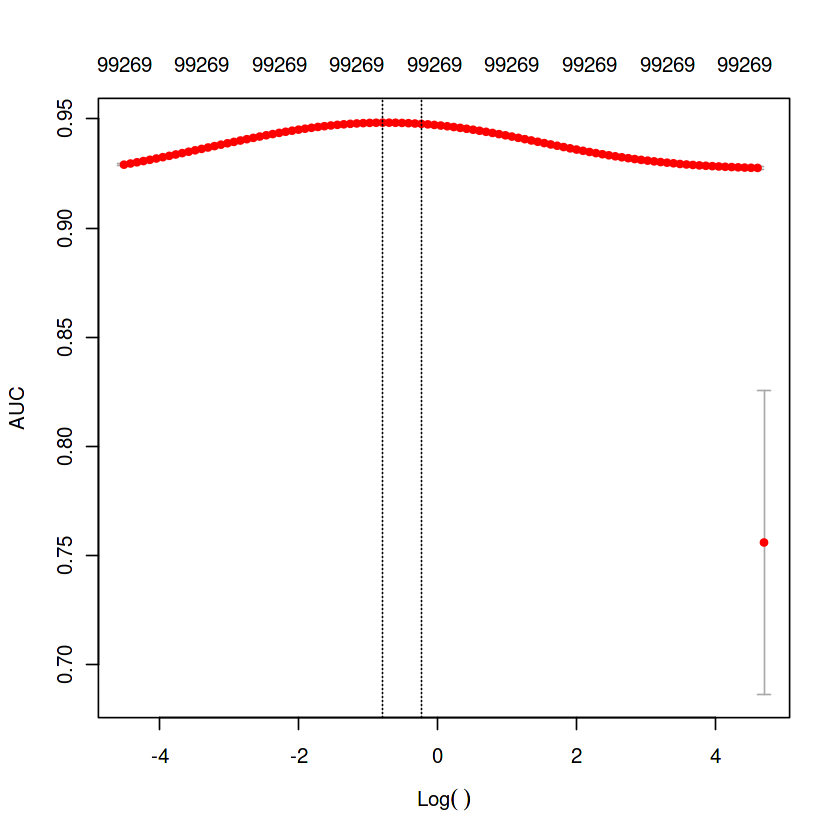

In [21]:
plot(cv_ridge)

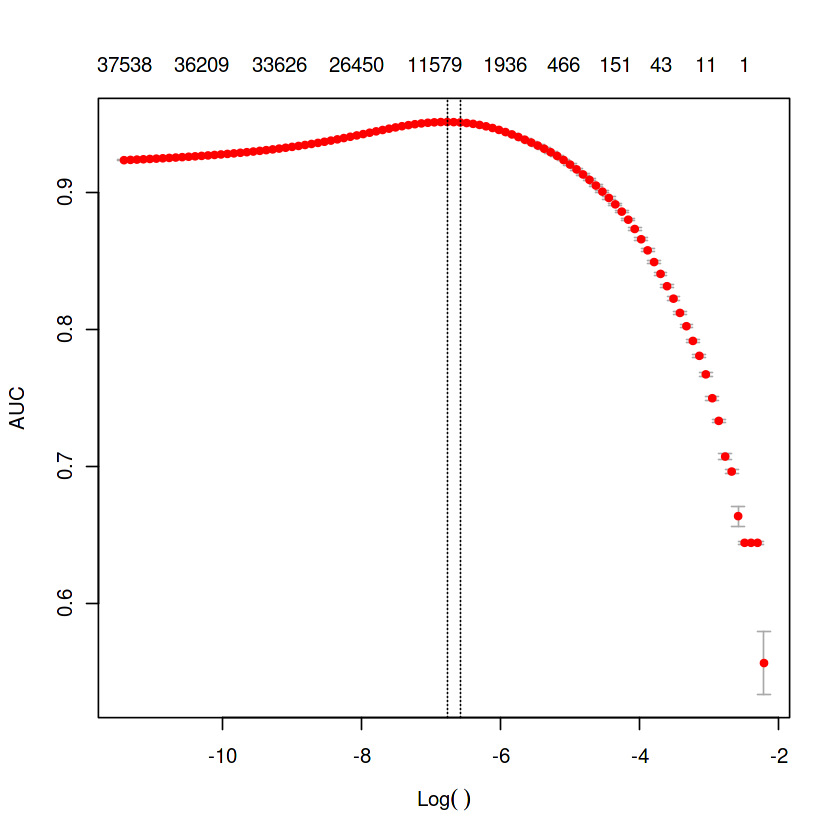

In [22]:
plot(cv_lasso)

## Model selection

- The AUC value of the optimal model with LASSO regularization is slightly greater than the one from the model with Ridge regularization, 0.951 vs 0.949. We will generate our final predictions from the LASSO model.

In [23]:
print(cv_ridge)
print(cv_lasso)


Call:  cv.glmnet(x = X_train, y = y_train, type.measure = "auc", nfolds = 10,      parallel = FALSE, trace.it = 1, family = "binomial", alpha = 0) 

Measure: AUC 

    Lambda Index Measure        SE Nonzero
min 0.4514    60  0.9483 0.0006134   99269
1se 0.7889    54  0.9477 0.0006186   99269

Call:  cv.glmnet(x = X_train, y = y_train, type.measure = "auc", nfolds = 10,      parallel = FALSE, trace.it = 1, family = "binomial") 

Measure: AUC 

      Lambda Index Measure        SE Nonzero
min 0.001144    50  0.9513 0.0004871    9068
1se 0.001379    48  0.9510 0.0004892    6775


## Exploring best predictors

- Import predictors

In [24]:
predictors <- cv_lasso %>%
  coef() %>%
  # Neccesary to convert from custom matrix object and not loose predictor names
  as.matrix %>% as.data.frame %>% 
  rownames_to_column("predictor") %>% 
  as_tibble() %>%
  rename(coef = 2)

head(predictors)

predictor,coef
<chr>,<dbl>
X.Intercept.,1.799487
X12,0.000000
X6,0.000000
X8,0.000000
a,0.000000
about,0.000000


- Print the predictors with the highest weight

In [25]:
predictors %>%
  arrange(desc(abs(coef))) %>%
  print(n = 50)

# A tibble: 99,270 x 2
   predictor          coef
   <chr>             <dbl>
 1 X3.stars          -55.8
 2 X4.stars           41.3
 3 two.stars         -40.8
 4 X2.stars          -37.5
 5 great              37.5
 6 three.stars       -36.9
 7 the               -34.5
 8 not.recommend     -33.6
 9 not               -30.3
10 love               29.0
11 four.stars         24.5
12 some.children     -24.0
13 X3.star           -23.4
14 perfect            23.3
15 not.worth         -23.3
16 loves              22.0
17 and.14             22.0
18 t                 -21.1
19 t.recommend       -21.1
20 disappointed      -21.0
21 pros.are          -20.9
22 returned          -20.9
23 smoothies.yogurt  -20.7
24 returning         -19.4
25 not.disappointed   19.1
26 poor              -19.0
27 useless           -19.0
28 return            -18.7
29 major.design      -17.7
30 not.happy         -17.4
31 not.buy           -17.4
32 claustrophobic    -17.4
33 disappointing     -17.4
34 did.love          -17.1
35 re

- We see that the best predictors mention a specific number of stars.
- Particularly, the best one are explicit mentions to "3 stars". This makes sense because those reviews are the hardest to identify as "satisfied" or not from the review contents.
- It is clear why some predictors could be the most predictive. However, there are a few unexpected features too like "and", "the" or "t".

# 6. Generate predictions

In [26]:
predictions <- predict(cv_lasso, newx = X_test, type = "response",  
                       s = "lambda.min")

In [27]:
output <- predictions %>%
  as_tibble() %>% 
  # Rename second column (predictions)
  rename(Prediction = 1) %>%
  mutate(Id = test_is) %>%
  select(Id, Prediction)%>%
  write_csv(file = "predictions.csv")

head(output)

Id,Prediction
<int>,<dbl>
3,0.9962293
5,0.9526747
8,0.9761294
14,0.7873864
20,0.9390355
22,0.2284825


- The IDs in the `.csv` file must match the IDs extracted from the test set.

In [28]:
all.equal(output$Id, test_is)

[1] TRUE

## Ridge predictions
- We are exporting them just so they are saved in the notebook output.

In [29]:
predictions_ridge <- predict(cv_ridge, newx = X_test, type = "response",  
                       s = "lambda.min")

output_ridge <- predictions_ridge %>%
  as_tibble() %>% 
  # Rename second column (predictions)
  rename(Prediction = 1) %>%
  mutate(Id = test_is) %>%
  select(Id, Prediction)%>%
  write_csv(file = "predictions_ridge.csv")

head(output_ridge)

Id,Prediction
<int>,<dbl>
3,0.9561078
5,0.8991637
8,0.9779888
14,0.6756025
20,0.8887083
22,0.5793157


# 7. Division of labor
## First submission
- Notebook setup: All
- Words `tf_idf` & sentiment analysis: David
- Bi-grams `tf_idf`: Jessica
- Total number of words: Félice
- Model fitting, model evaluation, submitting predictions: All

## Second submission
- Fixing mismatched ids: Jessica
- Added Ridge regression: Jessica
- Expanded model evaluation: Coba
- Cleaned-up notebook and writing: Félice